<a href="https://colab.research.google.com/github/AndrewKruszka/NeuralMachineLearning/blob/main/Project3_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Sleep Stage Classification using Local Field Potentials (LFPs) with LSTM

**Author:** Andrew Kruszka

**Introduction:**

This project aims to develop a deep learning model to classify sleep stages based on Local Field Potential (LFP) data using a Long Short-Term Memory (LSTM) network. LFPs are electrical recordings of brain activity that provide valuable insights into sleep architecture. We will be utilizing data from three different sources (Part1SubjectHB10.h5, Part2SubjectHB13.h5, and Rat08-20130711_017.h5), which likely contain recordings of LFP signals during different sleep stages.

**Objective:**

The primary goal is to build and train an LSTM model that can accurately classify raw LFP segments into two distinct sleep stages: NREM (Non-Rapid Eye Movement) and WAKE. This classification will be achieved by leveraging the LSTM's ability to learn temporal dependencies and patterns within the LFP data that are characteristic of each sleep stage.

**Methodology:**

The project will involve the following key steps:

1. **Data Loading and Preprocessing:**
   - Load raw LFP data from the provided HDF5 files.
   - Convert the data into a format suitable for the LSTM model (e.g., creating sequences of data points).
   - Split the data into training and validation sets.
2. **Model Development:**
   - Design and implement an LSTM network for classification.
   - Define the architecture of the LSTM, including the number of layers, hidden units, and activation functions.
3. **Model Training and Evaluation:**
   - Train the LSTM model using the preprocessed LFP data and corresponding sleep stage labels.
   - Evaluate model performance using metrics such as accuracy, loss, and potentially precision and recall.
4. **Visualization and Interpretation:**
   - Visualize the training and validation loss and accuracy curves to monitor the model's learning progress.
   - Analyze the model's predictions and potentially interpret its learned features to gain insights into sleep stage classification.

In [4]:
import h5py  # For reading HDF5 files
import numpy as np  # For numerical operations
import torch  # PyTorch core library
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimization algorithms
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split  # Data loading utilities
from scipy import signal
import matplotlib.pyplot as plt

## Data Loading and Preprocessing

This section downloads and processes LFP signal data from three HDF5 files. Each file contains two labeled brain states: `NREM` (label 0) and `WAKE` (label 1), with multiple clips under each group.

A helper function `load_file(filename)` reads all clips from the specified file, assigns labels based on the state, and ensures each clip is a fixed length by truncating or padding as needed.

After loading data from all three files:
- Data and labels are stored in NumPy arrays.
- The input features `X` and target labels `y` are converted to PyTorch tensors.
- A custom `LFPDataset` class is defined to wrap the tensors for training.
- A `DataLoader` is created to feed the data in shuffled mini-batches for model training.


In [5]:
# Download the files
!wget -q "https://github.com/AndrewKruszka/NeuralMachineLearning/raw/refs/heads/main/Part1SubjectHB10.h5"
!wget -q "https://github.com/AndrewKruszka/NeuralMachineLearning/raw/refs/heads/main/Part2SubjectHB13.h5"
!wget -q "https://github.com/AndrewKruszka/NeuralMachineLearning/raw/refs/heads/main/Rat08-20130711_017.h5"

# Initialize lists for all data and labels
data = []
labels = []

# Function to load labeled data from a file
def load_file(filename):
    with h5py.File(filename, 'r') as f:
        for state in ['NREM', 'WAKE']:
            label = 0 if state == 'NREM' else 1
            if state in f:
                for key in f[state].keys():
                    clip = f[state][key][:]
                    # Pad or truncate clips to a fixed length
                    desired_length = 40001  # Replace with your desired length
                    clip = clip[:desired_length]  # Truncate if longer
                    clip = np.pad(clip, (0, desired_length - len(clip)), 'constant')  # Pad if shorter
                    data.append(clip)
                    labels.append(label)

# Load from all three files
load_file('Part1SubjectHB10.h5')
load_file('Part2SubjectHB13.h5')
load_file('Rat08-20130711_017.h5')

# Convert to NumPy arrays
X = np.array(data)
y = np.array(labels)

# Convert and reshape to PyTorch tensors for LSTM
X_lstm = torch.tensor(X, dtype=torch.float32)
y_lstm = torch.tensor(y, dtype=torch.long)

# Reshape for LSTM: (batch_size, seq_len, input_size)
X_lstm = X_lstm.view(X_lstm.shape[0], 1, X_lstm.shape[1])

# Create dataset and split
dataset_lstm = TensorDataset(X_lstm, y_lstm)
train_size = int(0.8 * len(dataset_lstm))
val_size = len(dataset_lstm) - train_size
train_lstm, val_lstm = random_split(dataset_lstm, [train_size, val_size])

# Create data loaders
train_loader_lstm = DataLoader(train_lstm, batch_size=32, shuffle=True)
val_loader_lstm = DataLoader(val_lstm, batch_size=32) # Fixed typo here

## Feature Extraction from LFP Data

This section defines a function `preprocess_data` that transforms raw LFP signals into a matrix of features suitable for machine learning models.

### Function Overview

`preprocess_data(data, clip_length, sampling_rate)` performs the following steps:

1. **Clip Segmentation**  
   The raw signal is divided into fixed-length segments based on the specified clip duration (in seconds) and the sampling rate (in Hz).

2. **Feature Extraction per Clip**  
   For each clip, a set of features is computed:
   - Basic statistics: mean, standard deviation, skewness, and kurtosis
   - Power Spectral Density (PSD): frequency content below 50 Hz using Welch’s method
   - Band power: total power in a specified frequency band (e.g., 10–20 Hz)

3. **Feature Normalization**  
   All features are standardized using z-score normalization.

4. **Return Values**  
   Returns a 2D NumPy array `X` where each row corresponds to a clip and each column is a feature. Labels `y` must be manually specified depending on the source of the data.

This function is useful for converting raw neural signals into structured input for classification models.


In [6]:
import numpy as np
from scipy import signal

def preprocess_data(data, clip_length, sampling_rate):
    """
    Preprocesses raw LFP data into clips with extracted features.

    Args:
        data: Raw LFP signal data.
        clip_length: Length of each clip in seconds.
        sampling_rate: Sampling rate of the data in Hz.

    Returns:
        X: Feature matrix (num_clips, num_features).
        y: Label vector (num_clips,).
    """

    # Calculate clip size in samples
    clip_size = int(clip_length * sampling_rate)

    # Segment data into clips
    num_clips = len(data) // clip_size
    clips = [data[i * clip_size:(i + 1) * clip_size] for i in range(num_clips)]

    # Extract features from each clip
    X = []
    for clip in clips:
        # 1. Basic statistics
        features = [np.mean(clip), np.std(clip), signal.skew(clip), signal.kurtosis(clip)]

        # 2. PSD features (example with low frequency resolution)
        frequencies, psd = signal.welch(clip, fs=sampling_rate, nperseg=clip_size // 10)
        features.extend(psd[frequencies < 50])  # Select frequencies below 50 Hz

        # 3. Bandpass filtering and power calculation (example band: 10-20 Hz)
        bandpass_filtered = signal.sosfiltfilt(signal.butter(4, [10, 20], 'bandpass', fs=sampling_rate), clip)
        features.append(np.sum(bandpass_filtered**2))  # Band power

        X.append(features)

    X = np.array(X)

    # ... (Add labels based on your data format)
    # Example: y = np.zeros(num_clips)  # Assume all clips belong to state 0

    # Normalize features (e.g., using z-score)
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    return X, y

## Fully Connected Neural Network (FCNN)

This simple feedforward neural network consists of:

- **Input Layer**: Projects input features to a hidden layer
- **ReLU Activation**: Introduces non-linearity
- **Output Layer**: Maps hidden features to class scores (e.g., NREM vs WAKE)

It's designed for structured input like statistical or PSD-based features extracted from LFP clips.


In [7]:
class LFP_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LFP_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

## Model Training and Evaluation

This section trains a fully connected neural network to classify LFP clips as either `NREM` or `WAKE`.

### Setup

- **Hyperparameters** such as input size, hidden layer size, learning rate, and number of epochs are defined.
- The dataset is split into training (80%) and validation (20%) subsets using `random_split`.

### Training

- The model is trained using the Adam optimizer and Cross-Entropy loss.
- For each epoch, the model:
  - Performs forward and backward passes on the training data
  - Tracks training loss across mini-batches

### Validation

- After each epoch, the model is evaluated on the validation set.
- Validation loss and classification accuracy are computed without gradient updates.
- Accuracy is measured as the percentage of correctly predicted labels.

### Visualization

- After training, two plots are generated:
  - Training and validation loss over epochs
  - Validation accuracy over epochs

These plots help monitor the learning progress and identify potential overfitting or underfitting during training.


[LSTM] Epoch 1/10 | Train Loss: 0.6938 | Val Loss: 0.7038 | Accuracy: 38.46%
[LSTM] Epoch 2/10 | Train Loss: 0.6808 | Val Loss: 0.7074 | Accuracy: 48.72%
[LSTM] Epoch 3/10 | Train Loss: 0.6695 | Val Loss: 0.7147 | Accuracy: 51.28%
[LSTM] Epoch 4/10 | Train Loss: 0.6585 | Val Loss: 0.7211 | Accuracy: 43.59%
[LSTM] Epoch 5/10 | Train Loss: 0.6444 | Val Loss: 0.7298 | Accuracy: 43.59%
[LSTM] Epoch 6/10 | Train Loss: 0.6274 | Val Loss: 0.7421 | Accuracy: 41.03%
[LSTM] Epoch 7/10 | Train Loss: 0.6092 | Val Loss: 0.7530 | Accuracy: 46.15%
[LSTM] Epoch 8/10 | Train Loss: 0.5873 | Val Loss: 0.7659 | Accuracy: 48.72%
[LSTM] Epoch 9/10 | Train Loss: 0.5627 | Val Loss: 0.7833 | Accuracy: 46.15%
[LSTM] Epoch 10/10 | Train Loss: 0.5354 | Val Loss: 0.8113 | Accuracy: 46.15%


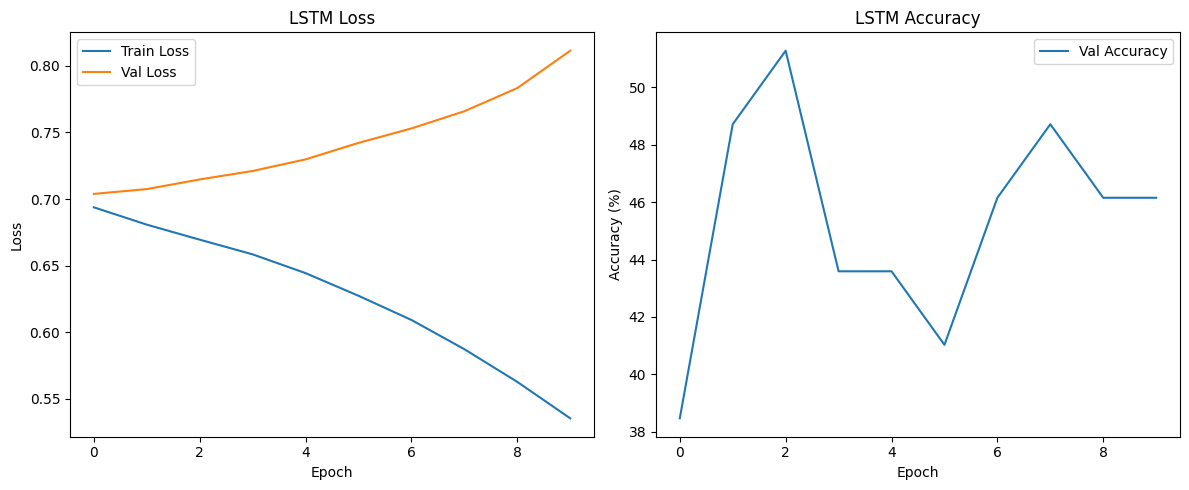

In [8]:
# --- LSTM Training and Evaluation Loop ---

# Assuming train_loader_lstm and val_loader_lstm are defined from Step 2
import matplotlib.pyplot as plt

# Model, optimizer, loss
input_size = X_lstm.shape[2]  # Input size for LSTM
hidden_size = 128  # Number of features in the hidden state
num_layers = 2  # Number of recurrent layers
num_classes = 2  # Number of output classes (NREM, WAKE)
model_lstm = LFP_LSTM(input_size, hidden_size, num_layers, num_classes)  # Instantiate the LSTM model
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Store losses and accuracy
lstm_train_loss = []
lstm_val_loss = []
lstm_val_acc = []

# Training loop
for epoch in range(10):  # Adjust the number of epochs as needed
    model_lstm.train()  # Set the model to training mode
    batch_losses = []
    for data, target in train_loader_lstm:
        optimizer.zero_grad()  # Reset gradients
        output = model_lstm(data)  # Forward pass
        loss = criterion(output, target)  # Calculate loss
        loss.backward()  # Backpropagate gradients
        optimizer.step()  # Update model weights
        batch_losses.append(loss.item())  # Store batch loss
    train_loss = sum(batch_losses) / len(batch_losses)  # Calculate average epoch loss
    lstm_train_loss.append(train_loss)  # Store training loss

    # Validation
    model_lstm.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    with torch.no_grad():  # Disable gradient calculation during validation
        for data, target in val_loader_lstm:
            output = model_lstm(data)
            val_loss += criterion(output, target).item()  # Accumulate validation loss
            pred = output.argmax(dim=1, keepdim=True)  # Get predicted class
            correct += pred.eq(target.view_as(pred)).sum().item()  # Count correct predictions

    val_loss /= len(val_loader_lstm)  # Calculate average validation loss
    accuracy = 100. * correct / len(val_loader_lstm.dataset)  # Calculate accuracy
    lstm_val_loss.append(val_loss)  # Store validation loss
    lstm_val_acc.append(accuracy)  # Store accuracy

    print(f"[LSTM] Epoch {epoch+1}/10 | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Accuracy: {accuracy:.2f}%")

# Plotting the training and validation curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lstm_train_loss, label='Train Loss')
plt.plot(lstm_val_loss, label='Val Loss')
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_val_acc, label='Val Accuracy')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

## Training and Validation Results (LSTM)

The LSTM model was trained for 10 epochs to classify brain states (NREM vs WAKE) using the raw LFP signal as input. Below is a summary of the observed performance:

### Loss Trends
- **Training loss:** The training loss gradually decreased from 0.6938 in the first epoch to 0.5354 in the final epoch. This indicates that the model is learning and fitting the training data progressively better.
- **Validation loss:** The validation loss, however, steadily increased from 0.7038 to 0.8113 across the epochs. This suggests that the model is overfitting to the training data and not generalizing well to unseen data.

### Accuracy Trends
- **Validation accuracy:** The validation accuracy fluctuated throughout the training process, reaching its highest value of 51.28% in the 3rd Epoch.
- The highest accuracy achieved was 51.28% at epoch 3. After this point, the accuracy remained around 46.15% for the remaining epochs.
- Overall, the accuracy remained relatively low, indicating a limited ability of the model to effectively distinguish between the two brain states (NREM and WAKE). The model performs only slightly better than random chance (50%).

### Interpretation
- The increasing validation loss alongside the decreasing training loss, and fluctuating accuracy, clearly indicates overfitting. The model is learning patterns specific to the training data but fails to generalize those patterns to new, unseen data.
- Possible reasons for the observed performance include:
    - The inherent complexity and noise present in the raw LFP signal might make it challenging for the LSTM to extract relevant features for accurate classification.
    - The chosen LSTM architecture and hyperparameters might not be optimal for this specific task.
    - The limited amount of training data could also contribute to overfitting.

### Potential Improvements
- To improve the model's performance, consider the following:
    - **Adjusting model capacity:** Experiment with different hidden sizes and numbers of layers in the LSTM to find a better balance between capacity and generalization.
    - **Regularization:** Apply techniques like dropout or weight decay to reduce overfitting by preventing the model from relying too heavily on specific features in the training data.
    - **Data augmentation:** Generating synthetic data or applying transformations to the existing data could increase the training set size and improve the model's ability to generalize.
    - **Hyperparameter tuning:** Optimize the learning rate, batch size, and other hyperparameters to find the best settings for this task.